In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [2]:
def gen_range(value_start, value_end, value_step):
    """
    range関数を小数点が扱えるように拡張。value_startから始めてvalue_endに到達するまでvalue_stepを加え続ける。計算を実行する毎にその値を返す。
    ----------------
    Parameter
        value_start:float
        value_end:float
        value_step:float
    ----------------
    ----------------
    Return
    　　value:float value_minにvalue_stepを加えた値
    ----------------
    """
    value = value_start
    while value+value_step < value_end:
     yield value
     value += value_step

In [3]:
def binning_data(data_source, col_name, binned_col_name, num_of_bin=10, option="IQR"):
    """
    指定された列を指定されたbinの数に分割し、bin毎にラベル付けされたデータを元データに追加する
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    binned_col_name : string 
    num_of_bin : int
    
    return
    --------------
    data_source : pandas dataframe
    
    """
    
    if option == "IQR":
        #bin幅の決定のため四分位数を調べる。（外れ値を除く）
        data_info = data_source.describe()
        bin_min = data_info.loc["25%", col_name]
        bin_max = data_info.loc["75%", col_name]
        IQR = bin_max - bin_min
        bin_min = bin_min-IQR*1.5 if bin_min > IQR*1.5 else 0 #これ以下は外れ値とする。(0を最低値とする)
        bin_max += IQR*1.5 #これ以上は外れ値とする
        bin_min = (int)(bin_min)
        bin_max = (int)(bin_max)+1
    elif option == "MINMAX":
        data_info = data_source.describe()
        bin_min = (int)(data_info.loc["min", col_name])
        bin_max = (int)(data_info.loc["max", col_name])+1    
    
    bin_width = (int)((bin_max - bin_min) / num_of_bin)
    bins = [value for value in range(bin_min, bin_max, bin_width)]
    #bin_width = (bin_max - bin_min) / num_of_bin
    #bins = [value for value in gen_range(bin_min, bin_max, bin_width )]
    labels = [i for i in range(0, len(bins)-1)]
    binned_label = pd.cut(data_source[col_name], bins=bins, labels=labels)
    data_source[binned_col_name] = binned_label

    for i in range(0, len(bins)-1):
        print("range label={} : range={:.5f}~{:.5f}".format(i, bins[i], bins[i+1]) )
    
    return data_source

In [4]:
def plot_non_repayment_rate(data_source, col_name, flag_rename_x_label=False):
    """
    X軸を指定された列として未偏差率を棒グラフでプロット
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    flag_rename_x_label : bool
    
    return
    --------------
    None
    """
    
    #ラベル毎に返済率を算出
    non_repayment_rate = data_source.groupby(col_name, as_index=False).mean()
    non_repayment_rate["TARGET"] *= 100
    #print(non_repayment_rate)
    
    #Bar plot
    plt.figure(figsize=(25,10))
    plt.bar(non_repayment_rate.index, non_repayment_rate["TARGET"], color="Blue")
    plt.xlabel(col_name, fontsize=18)
    plt.ylabel("Non-payment rate[%]", fontsize=18)
    plt.title("Non-payment rate")
    plt.tight_layout()
    
    #グラフ上に数値表示
    """
    for x, y in zip(non_repayment_rate.index, non_repayment_rate["TARGET"]):
        plt.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
        if flag_rename_x_label == True:
            plt.xticks(non_repayment_rate.index, non_repayment_rate[col_name]) #x軸を実際のデータラベルへ置き換え
    """
    plt.show()

### 【問題1】パイプラインの作成
授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。

### パイプライン関数

In [5]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def pipline(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    #学習データ、テストデータに分ける
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
    train_feature = train_data[feature_value].values
    train_target = train_data[target_value].values
    test_feature = test_data[feature_value].values
    test_target = test_data[target_value].values
    print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
    
    #学習データの特徴量を標準化
    if normalization == True:
        scaler = StandardScaler()
        scaler.fit(train_feature)
        train_feature = scaler.transform(train_feature)
        scaler.fit(test_feature)
        test_feature = scaler.transform(test_feature)

    #学習と予測
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
    
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    #rocをplot
    if plot == True:
        plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.show()
    
    return result, fpr, tpr, thresholds

### 試しにirisデータで計算してみる  
期待通り動いていそう。

In [6]:
from sklearn.datasets import load_iris
iris_data_set = load_iris()
x = pd.DataFrame(iris_data_set.data, columns=iris_data_set.feature_names)    #Put explanatory variable into x as pandasdata frame
y = pd.DataFrame(iris_data_set.target, columns=['Species'])    #Put iris response variable into y as pandasdata frame
df = pd.concat([x, y], axis=1)
data = df[df["Species"] != 0]

元データ数：100　学習データ数：75　検証データ数：25


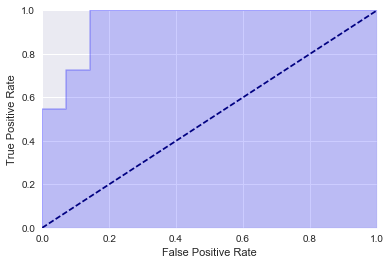

Result=[0.02 0.   0.   0.99 1.   1.   0.59 0.   0.94 0.92 1.   1.   0.59 0.03
 0.01 0.93 0.8  0.45 1.   1.   0.   0.77 0.83 0.99 0.16]
FPR=[0.         0.         0.         0.07142857 0.07142857 0.14285714
 0.14285714 0.42857143 0.57142857 1.        ]
TPR=[0.         0.36363636 0.54545455 0.54545455 0.72727273 0.81818182
 1.         1.         1.         1.        ]
Thresholds=[2.   1.   0.98 0.97 0.55 0.41 0.2  0.06 0.01 0.  ]


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=10)
#clf = KNeighborsClassifier(n_neighbors=3)

result, fpr, tpr, thresholds = pipline(clf, data, "Species", data.columns[[0,2]], 2, False)

print("Result={}".format(result[:,0]))
print("FPR={}".format(fpr))
print("TPR={}".format(tpr))
print("Thresholds={}".format(thresholds))

### 実際に計算

特徴量を選ぶ(とりあえず前回のEDAの結果)  
1.OCCUPATION_TYPE  
2.ORGANIZATION_TYPE  
5.DAYS_EMPLOYED  
6.DAYS_REGISTRATION  
7.AMT_CREDIT  
8.DAYS_BIRTH  
9.DEF_60_CNT_SOCIAL_CIRCLE  
10.AMT_INCOME_TOTAL  
11.CNT_CHILDREN  

In [8]:
import copy
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE",
                         "EXT_SOURCE_1",
                         "EXT_SOURCE_2",
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", 
                         "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL", 
                         "CNT_CHILDREN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [9]:
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/week3/session/all/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [10]:
pd_reducted_train_data = pd_application_train[col_name]

In [11]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


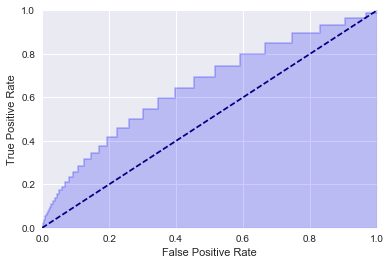

AUC=0.67154


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#clf = KNeighborsClassifier(n_neighbors=5)
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

モデルのパラメータ調整？？

### 【問題2】指標値の関数作成
このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）
このAUCを計算する関数を作成してください。

In [13]:
def cal_auc(fpr, tpr):
    
    dx = fpr[1:]-fpr[:-1]     #X軸（fpr）について配列の隣同士の間隔を計算
    dy = (tpr[1:]+tpr[:-1])/2 #Y軸(tpr)について配列の右隣との平均値を計算
    integral = dx*dy
    """
    integral_under = dx * tpr[0:len(tpr)-1]
    integral_over = dx * tpr[1:len(tpr)]
    auc = (integral_under.sum()+integral_over.sum())/2
    """
    return integral.sum()

#### AUCを計算 (Sklearn Metric.aucの計算結果と比較)  
結果、sklearnによる計算結果と一致した。

In [14]:
print("AUC(with cal_auc)={:.6f}".format(cal_auc(fpr, tpr)))
print("AUC(with metrics.auc)={:.6f}".format(metrics.auc(fpr, tpr)))

AUC(with cal_auc)=0.671544
AUC(with metrics.auc)=0.671544


### 【問題3】前処理・Feature Engineering・学習
精度を上げるために前処理・Feature Engineeringを行ってください。そしてその特徴量によって学習、検証、再び前処理の流れを繰り返しましょう。この工程はEDAの続きとも言えます。Week3で学んだことを思い出しながら進めてください。
汎化性能が高いモデルが作成できたと判断した場合は再びKaggleに提出をしましょう。

#### アプローチ ：データセットに新たな特徴量を加えてみる
負債を抱える人は、  
・複数ローンをしている  
・自己管理ができない、時間にルーズなど”いい加減” 
という特徴があるようだ。(ただし日本国内での調査結果に基づく)。
このことは、Week3 Seesion1で行なったEDAの結果、収入の他にその人物の特徴も重要な要素であるという推測と一致する。そこで、Home creditから与えられているデータを組み合わせ”いい加減”という特徴を数値化し新しい特徴量とすることを試みる。  
また、負債を抱えてしまった理由としては、  
・収入が少ない&収入の減少  
が上位に挙げられていた。しかしWeek3 Seesion1で行なったEDAの結果、単純に収入だけでは未返済率にはっきりとした傾向は現れていなかった。そこで、新たなアプローチとして収入と必要な出費から"経済的な余裕の無さ"を数値化し新しい特徴量とすることを試みる。必要な出費の多さの指標として”子供の多さ”を用いる。

| ”無計画” & ”いい加減” の定義　| 組み合わせる特徴量 |　新しい特徴量の算出方法 |
|:-----------:|:------------:|:------------:|
| 収入低いのに多く借りている |　AMT_INCOME_TOTAL, AMT_CREDIT, AMT_GOODS_PRICE | 得点化 |
| Nanの欄が多い | Nan | サンプル毎のNanの合計値の分布を適当なレンジに分ける。 |

| ”経済的な余裕のなさ”の定義| 組み合わせる特徴量 |　新しい特徴量の算出方法 |
|:-----------:|:------------:|:------------:|
| 収入が低く子供が多い　　　|　　　AMT_INCOME_TOTAL, CNT_CHILDREN　　　 | 　得点化 （収入=低い&子供多い=>大 　収入=高い&子供少い=>大）|

AMT_INCOME_TOTAL、 CNT_CHILDREN、AMT_CREDIT、 AMT_GOODS_PRICE、 Nanの分布を見てみる。

In [15]:
col_name = ["TARGET", "AMT_INCOME_TOTAL", "CNT_CHILDREN", "AMT_CREDIT", "AMT_GOODS_PRICE"]
pd_data = pd_application_train[col_name]
pd_data.head()

,TARGET,AMT_INCOME_TOTAL,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE
0,1,202500.0,0,406597.5,351000.0
1,0,270000.0,0,1293502.5,1129500.0
2,0,67500.0,0,135000.0,135000.0
3,0,135000.0,0,312682.5,297000.0
4,0,121500.0,0,513000.0,513000.0


In [16]:
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 5 columns):
TARGET              307511 non-null int64
AMT_INCOME_TOTAL    307511 non-null float64
CNT_CHILDREN        307511 non-null int64
AMT_CREDIT          307511 non-null float64
AMT_GOODS_PRICE     307233 non-null float64
dtypes: float64(3), int64(2)
memory usage: 11.7 MB


In [17]:
pd_data.describe()

,TARGET,AMT_INCOME_TOTAL,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE
count,307511.000000,3.075110e+05,307511.000000,3.075110e+05,3.072330e+05
mean,0.080729,1.687979e+05,0.417052,5.990260e+05,5.383962e+05
std,0.272419,2.371231e+05,0.722121,4.024908e+05,3.694465e+05
min,0.000000,2.565000e+04,0.000000,4.500000e+04,4.050000e+04
25%,0.000000,1.125000e+05,0.000000,2.700000e+05,2.385000e+05
50%,0.000000,1.471500e+05,0.000000,5.135310e+05,4.500000e+05
75%,0.000000,2.025000e+05,1.000000,8.086500e+05,6.795000e+05
max,1.000000,1.170000e+08,19.000000,4.050000e+06,4.050000e+06


#### 1."収入低いのに多く借りている"について、AMT_INCOME_TOTAL, AMT_CREDIT, AMT_GOODS_PRICEから数値化

income
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
AMT_CREDIT


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


range label=0 : range=0.00000~202078.00000
range label=1 : range=202078.00000~404156.00000
range label=2 : range=404156.00000~606234.00000
range label=3 : range=606234.00000~808312.00000
range label=4 : range=808312.00000~1010390.00000
range label=5 : range=1010390.00000~1212468.00000
range label=6 : range=1212468.00000~1414546.00000
range label=7 : range=1414546.00000~1616624.00000
AMT_GOODS_PRICE
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000


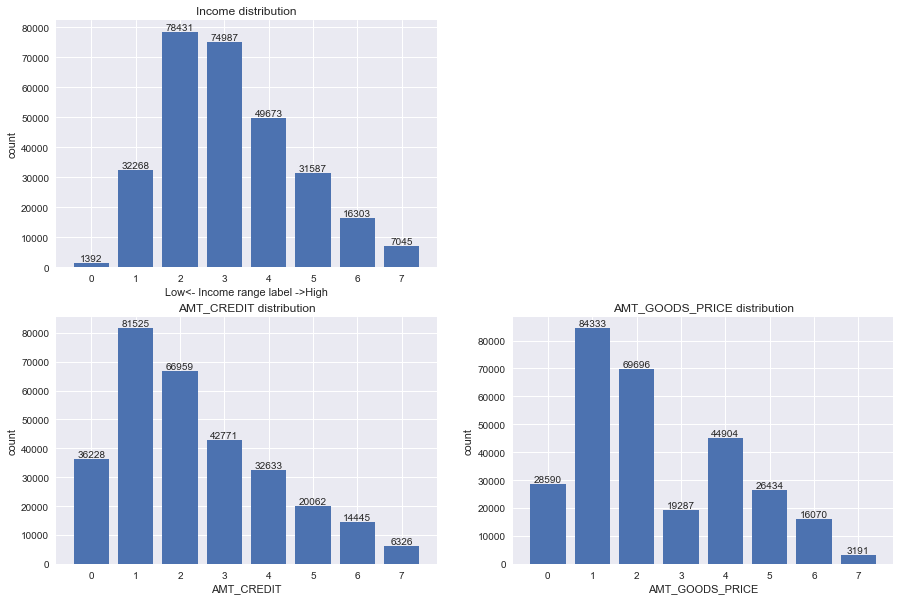

In [18]:
#Income range と 子供の数をcount plot
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (1,1))

ax1.set_title('Income distribution')
ax1.set_xlabel('Low<- Income range label ->High')
ax1.set_ylabel('count')
ax1.grid(True)

ax2.set_title('AMT_CREDIT distribution')
ax2.set_xlabel('AMT_CREDIT')
ax2.set_ylabel('count')
#plt.xlim([-1,15])
#plt.yscale("log")
ax2.grid(True)

ax3.set_title('AMT_GOODS_PRICE distribution')
ax3.set_xlabel('AMT_GOODS_PRICE')
ax3.set_ylabel('count')
#plt.xlim([-1,15])
#cale("log")
ax3.grid(True)

#Income
print("income")
tmp = binning_data(pd_data, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_INCOME_TOTAL", as_index=False).count()
ax1.bar(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
                , income_destribution_w_income_range["TARGET"]):
    ax1.text(x, y, y, ha='center', va='bottom')

#AMT_CREDIT
print("AMT_CREDIT")
tmp = binning_data(pd_data, "AMT_CREDIT", "BIN_AMT_CREDIT", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_CREDIT", as_index=False).count()
ax2.bar(income_destribution_w_income_range["BIN_AMT_CREDIT"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_CREDIT"]
                , income_destribution_w_income_range["TARGET"]):
    ax2.text(x, y, y, ha='center', va='bottom')

#AMT_GOODS_PRICE
print("AMT_GOODS_PRICE")
tmp = binning_data(pd_data, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_GOODS_PRICE", as_index=False).count()
ax3.bar(income_destribution_w_income_range["BIN_AMT_GOODS_PRICE"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_GOODS_PRICE"]
                , income_destribution_w_income_range["TARGET"]):
    ax3.text(x, y, y, ha='center', va='bottom')
    
plt.show()

３つの特徴量は数値の高い方向に外れ値を持っており、この値はレンジ分けする際に範囲外"Nan"となっている。新しい指標を導入する際にこのNanは全て10に置き換える。  

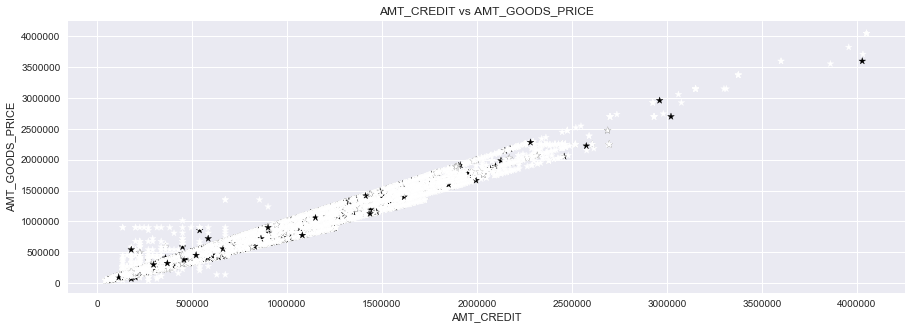

In [19]:
plt.figure(figsize=(15,5))
plt.title('AMT_CREDIT vs AMT_GOODS_PRICE')
plt.xlabel('AMT_CREDIT')
plt.ylabel('AMT_GOODS_PRICE')
plt.scatter(pd_data["AMT_CREDIT"], pd_data["AMT_GOODS_PRICE"], s=50, c=pd_data["TARGET"], marker='*')
plt.show()

In [20]:
x = pd_data["AMT_CREDIT"]
y = pd_data["AMT_GOODS_PRICE"]
x = x.replace(np.nan, -1)
y = y.replace(np.nan, -1)
np.corrcoef(x, y)

array([[1.       , 0.9866873],
       [0.9866873, 1.       ]])

"AMT_CREDIT" と "AMT_GOODS_PRICE"の相関係数はほぼ１なので、新しい指標の算出にはどちらか一方を用いる。
ここでは"AMT_GOODS_PRICE"を用いる。

"収入低いのに多く借りている"について、新しい指標を次のように定義する。  
(10 - INCOME_RANGE) $\times$ (1 + GOODS_PRICE_RANGE)  
以下、新しい指標をデータセットに追加する。  
  
＊(10 - INCOME_RANGE) => 収入が低いほど値が高い。INCOME_RANGEは値が低いほど収入が低いため、意味合いを逆転させるために10からINCOME_RANGEを引いた。(INCOME_RANGEの最大値は10)  
＊(1 + GOODS_PRICE_RANGE) => 借入額が高いほど値が高い。GOODS_PRICE_RANGEが0から始まるため１を加えた。  

In [21]:
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_train, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["BIN_AMT_GOODS_PRICE"])

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000


In [22]:
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"].describe()

count    292505.000000
mean         21.528658
std          12.136719
min           0.000000
25%          14.000000
50%          18.000000
75%          28.000000
max          80.000000
Name: DEG_IRESP_INCOME_GOODS_PRICE, dtype: float64

新しい指標"DEG_IRESP_INCOME_GOODS_PRICE"の有効性を確認するために、未返済率との関係を見てみる。

range label=0 : range=0.00000~10.00000
range label=1 : range=10.00000~20.00000
range label=2 : range=20.00000~30.00000
range label=3 : range=30.00000~40.00000
range label=4 : range=40.00000~50.00000
range label=5 : range=50.00000~60.00000
range label=6 : range=60.00000~70.00000
range label=7 : range=70.00000~80.00000


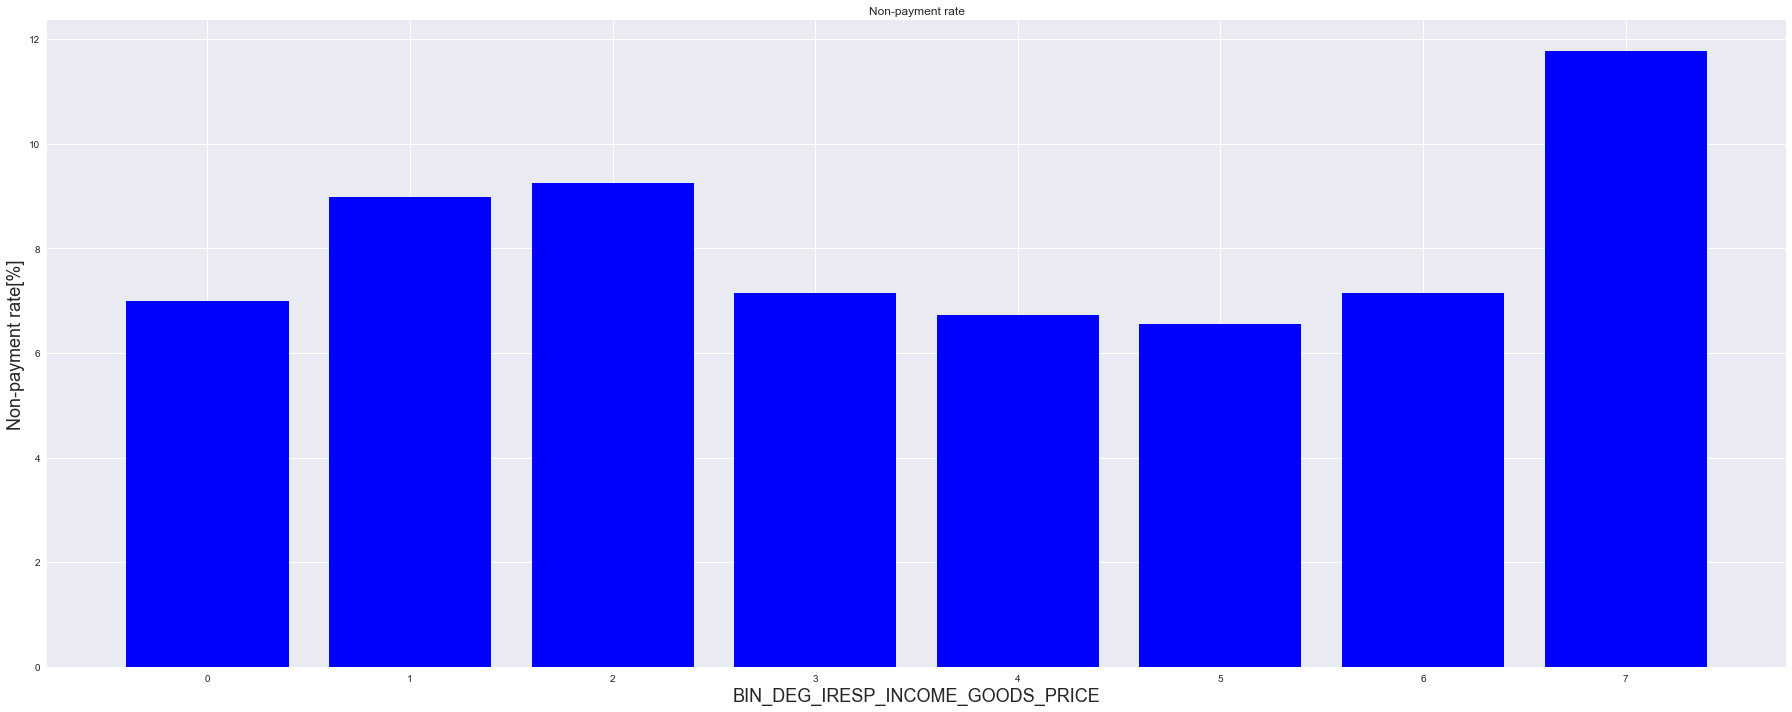

In [23]:
binning_data(pd_application_train, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")
plot_non_repayment_rate(pd_application_train, 'BIN_DEG_IRESP_INCOME_GOODS_PRICE', False)

期待としては、新しい指標"DEG_IRESP_INCOME_GOODS_PRICE"が大きいほど未返済率が大きいだったが、実際に指標を導入して関係を調べてみた結果、期待したような右肩あがりの関係は見えられなかった。  
よって、新しい指標"DEG_IRESP_INCOME_GOODS_PRICE"は未返済率の予測に適用しない。

#### 2."Nanの欄が多い"について
index毎にNanの合計値を算出する。適当なレンジに分けてNanの数の分布を見てみる。Nanが多い＝いい加減と考える。

In [24]:
pd_application_train["NUM_OF_NAN"] = pd_application_train.isnull().sum(axis=1)

In [25]:
pd_application_train["NUM_OF_NAN"].describe()

count    307511.000000
mean         29.949976
std          20.883310
min           0.000000
25%           6.000000
50%          37.000000
75%          49.000000
max          64.000000
Name: NUM_OF_NAN, dtype: float64

range label=0 : range=0.00000~6.00000
range label=1 : range=6.00000~12.00000
range label=2 : range=12.00000~18.00000
range label=3 : range=18.00000~24.00000
range label=4 : range=24.00000~30.00000
range label=5 : range=30.00000~36.00000
range label=6 : range=36.00000~42.00000
range label=7 : range=42.00000~48.00000
range label=8 : range=48.00000~54.00000
range label=9 : range=54.00000~60.00000


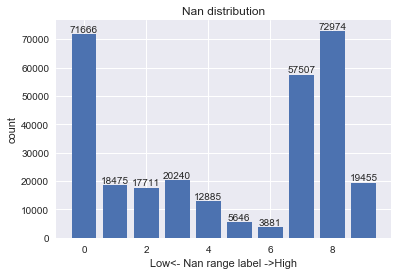

In [26]:
tmp = binning_data(pd_application_train, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")
nan_destribution_w_range = tmp.groupby("BIN_NUM_OF_NAN", as_index=False).count()

plt.title('Nan distribution')
plt.xlabel('Low<- Nan range label ->High')
plt.ylabel('count')
plt.grid(True)
plt.bar(nan_destribution_w_range["BIN_NUM_OF_NAN"]
        , nan_destribution_w_range["TARGET"])

for x, y in zip(nan_destribution_w_range["BIN_NUM_OF_NAN"]
                , nan_destribution_w_range["TARGET"]):
    plt.text(x, y, y, ha='center', va='bottom')

Nanの合計の分布を見てみると、Range0(Nanの数が0~6)のきっちりアンケートを記入しているグループとRange7~9(Nanの数が42~60)の比較的未記入が多いグループにざっくり分かれている。Range7~9はアンケート回答者の全体の半数を占める。
Range0のグループは、質問数の多さにも関わらずきっちり回答しており真面目な性格だと予想できる。
以下、未返済率との関係を調べてみる。

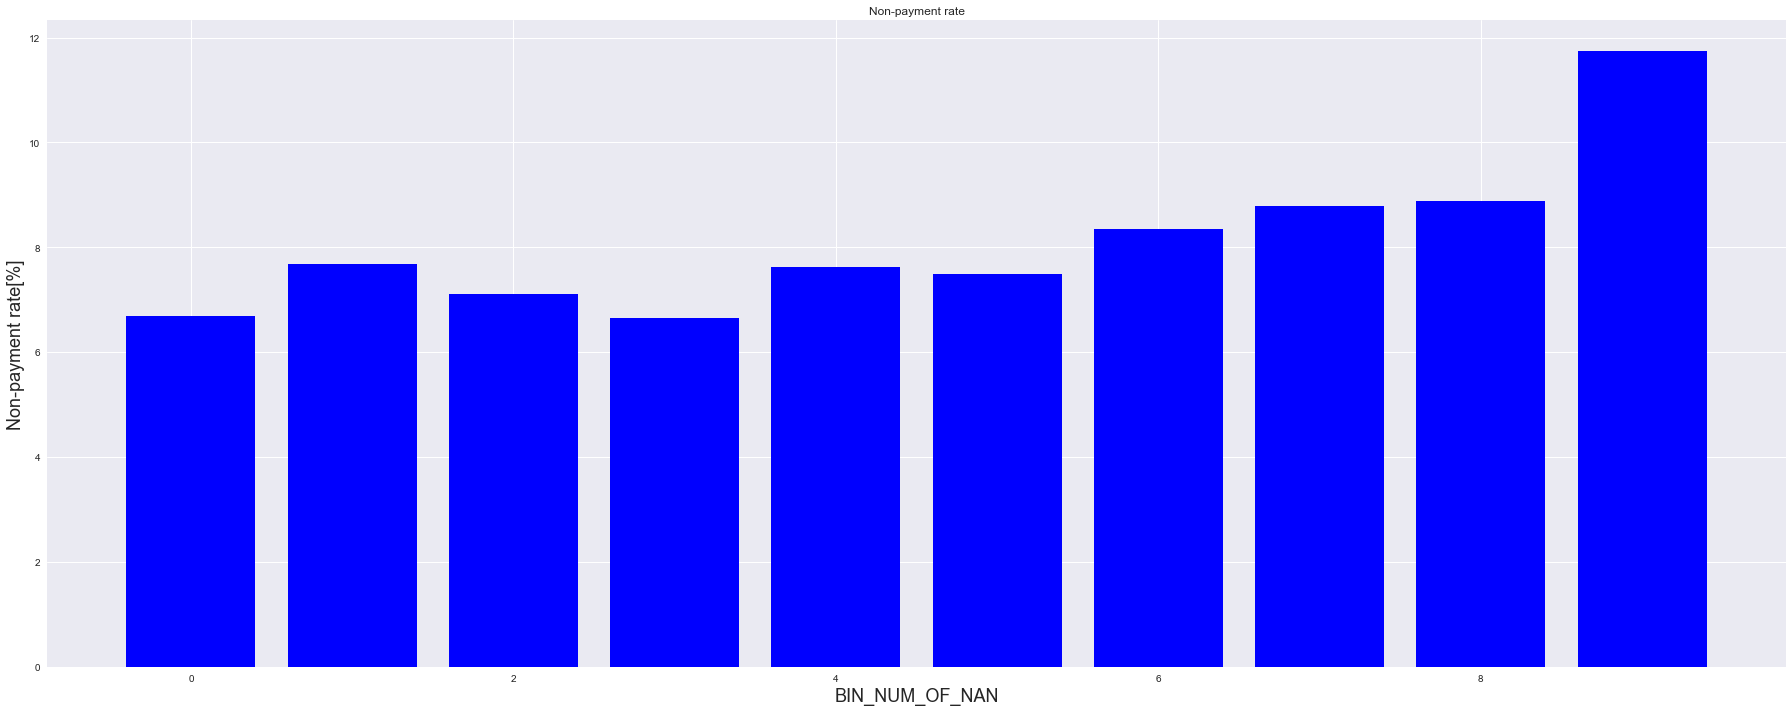

In [27]:
plot_non_repayment_rate(pd_application_train, 'BIN_NUM_OF_NAN', False)

プロットからは僅かであるが右肩上がりの傾向が見える。つまり、Nanが少ないほど未返済率が低く、Nanが多いほど未返済率が高い傾向があると言えそうだ。特にRange0とRange9では約2倍近い差が出ている。よって、Nanの数は未返済率の予測に使えそうな特徴量である。

#### 3."”経済的な余裕のなさ”の数値化について

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000


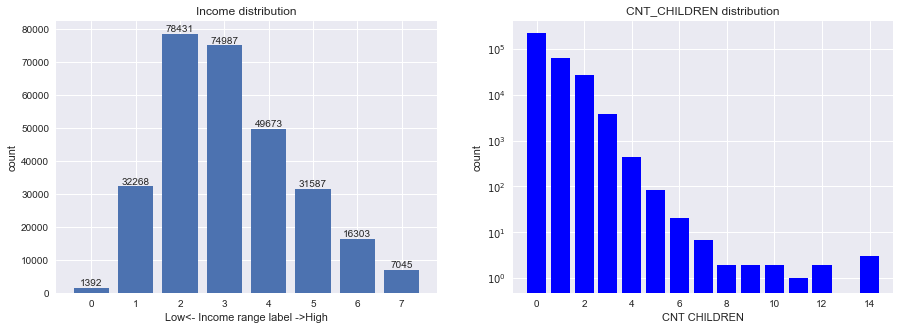

In [28]:
#Income range と 子供の数をcount plot
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))


ax1.set_title('Income distribution')
ax1.set_xlabel('Low<- Income range label ->High')
ax1.set_ylabel('count')
ax1.grid(True)

ax2.set_title('CNT_CHILDREN distribution')
ax2.set_xlabel('CNT CHILDREN')
ax2.set_ylabel('count')
plt.yscale("log")
plt.xlim([-1,15])
ax2.grid(True)

#Income
tmp = binning_data(pd_data, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_INCOME_TOTAL", as_index=False).count()
ax1.bar(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
                , income_destribution_w_income_range["TARGET"]):
    ax1.text(x, y, y, ha='center', va='bottom')

#子供の数
cnt_children_destribution = tmp.groupby("CNT_CHILDREN", as_index=False).count()
ax2.bar(cnt_children_destribution["CNT_CHILDREN"], cnt_children_destribution["TARGET"], color="Blue")
    
#グラフ上に数値表示
"""
for x, y in zip(cnt_children_destribution.index, cnt_children_destribution["TARGET"]):
    ax2.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
"""
plt.show()

顧客の半分ほどは子供がいないことがわかった。利用者は未婚、若者が多い可能性がある。

"経済的な余裕のなさ"について、新しい指標として(10 - INCOME_RANGE) $\times$ CNT_CHILDRENを導入する。  
この値はその人物の経済的な負荷を表す。（収入が少なくて子供多い=>大 　収入が多くて子供少ない=>小）  
AMT_INCOME_TOTALには収入が高い方向に大きな外れ値が存在していて、この値はINCOME_RANGEでは範囲外"Nan"となっている。新しい指標を導入する際にこのNanは全て10に置き換える。

In [29]:
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["CNT_CHILDREN"])

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000


In [30]:
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"].describe()

count    307511.000000
mean          9.167067
std           5.696633
min           0.000000
25%           6.000000
50%           8.000000
75%          10.000000
max         160.000000
Name: DEG_SEVERITY_INCOME_CNT_CHILDREN, dtype: float64

In [31]:
binning_data(pd_application_train, "DEG_SEVERITY_INCOME_CNT_CHILDREN", "BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN", 10, "MINMAX" )
"""
"""

range label=0 : range=0.00000~16.00000
range label=1 : range=16.00000~32.00000
range label=2 : range=32.00000~48.00000
range label=3 : range=48.00000~64.00000
range label=4 : range=64.00000~80.00000
range label=5 : range=80.00000~96.00000
range label=6 : range=96.00000~112.00000
range label=7 : range=112.00000~128.00000
range label=8 : range=128.00000~144.00000
range label=9 : range=144.00000~160.00000


'\n'

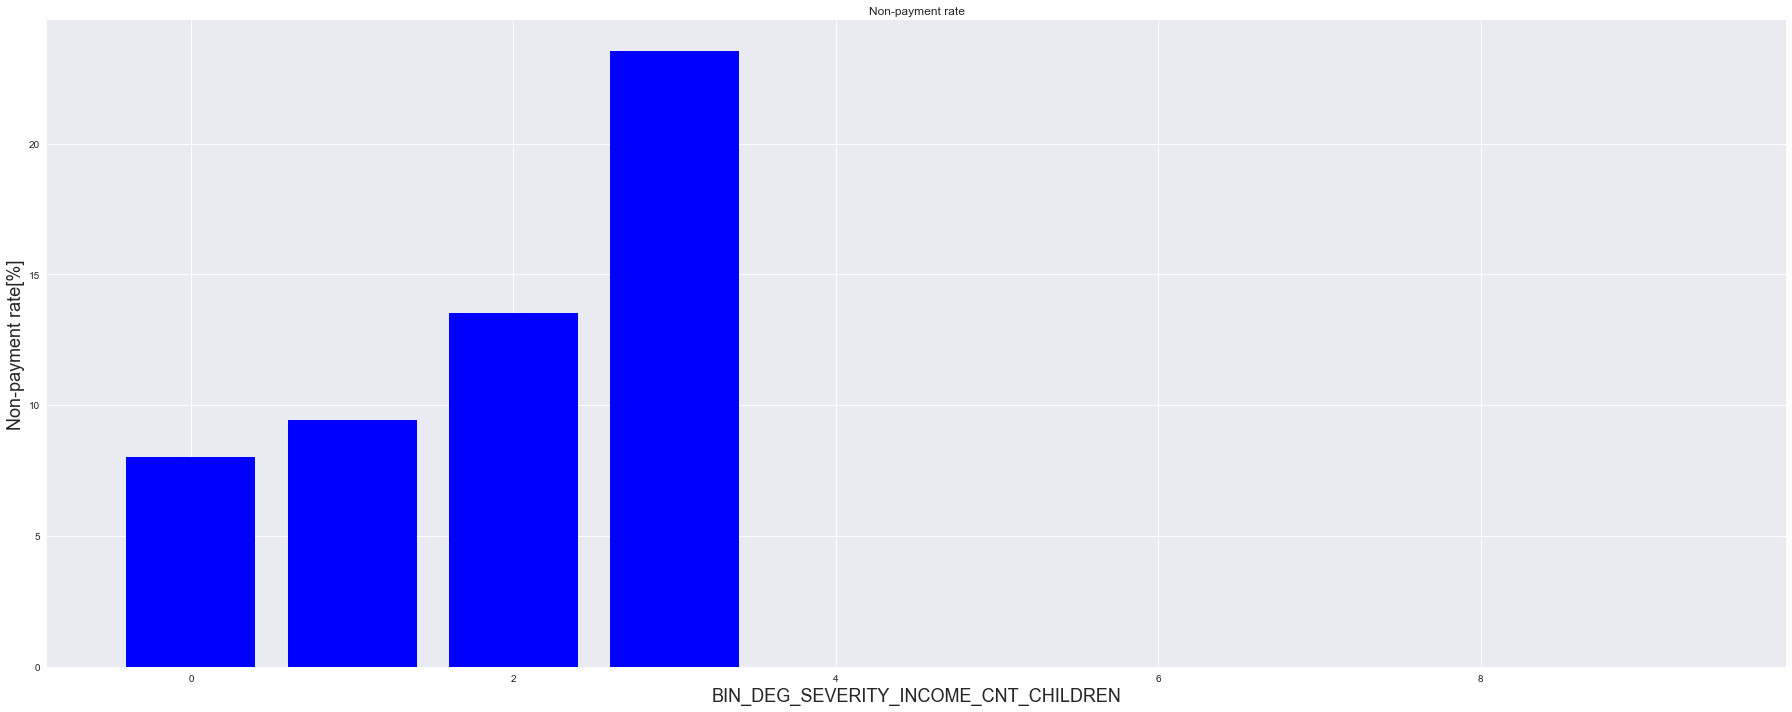

In [32]:
plot_non_repayment_rate(pd_application_train, 'BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN', False)

新しい特徴量"DEG_SEVERITY_INCOME_CNT_CHILDREN"は顧客の経済的な負担を数値化したもので、数値の増加ととも未返済率が増えると考えられる。
プロットのrange4以降はサンプル数が0~2しかなく且つ"Target"が0であるため未返済率は0と計算されている。そのためサンプルが集中しているRange0~3の間で考察を行うと期待した右肩あがりの傾向が見える。
よって、特徴量"DEG_SEVERITY_INCOME_CNT_CHILDREN"は未返済率の予測に使えそうな特徴量であると考えられる。

#### 新しい特徴量を加えてランダムフォレストで重要度を調べてみる

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [34]:
#SK_ID_CURRを削除する
pd_test = pd_application_train.drop("SK_ID_CURR", axis=1)
pd_test.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIN_AMT_INCOME_TOTAL,BIN_AMT_GOODS_PRICE,DEG_IRESP_INCOME_GOODS_PRICE,BIN_DEG_IRESP_INCOME_GOODS_PRICE,NUM_OF_NAN,BIN_NUM_OF_NAN,DEG_SEVERITY_INCOME_CNT_CHILDREN,BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2,18.0,1,1,0,6.0,0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6,28.0,2,2,0,4.0,0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [35]:
#オブジェクト型を数値に置き換え
object_col_name = pd_test.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_test[object_col_name[i]])
    pd_test[object_col_name[i]] = labels    

pd_test = pd_test.replace(np.nan, -1)

In [36]:
#ランダムフォレストを使って各パラメータの重要度を調べる
target = pd_test['TARGET']
feature = pd_test.iloc[:,1:len(pd_test.columns)]
model.fit(feature, target)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

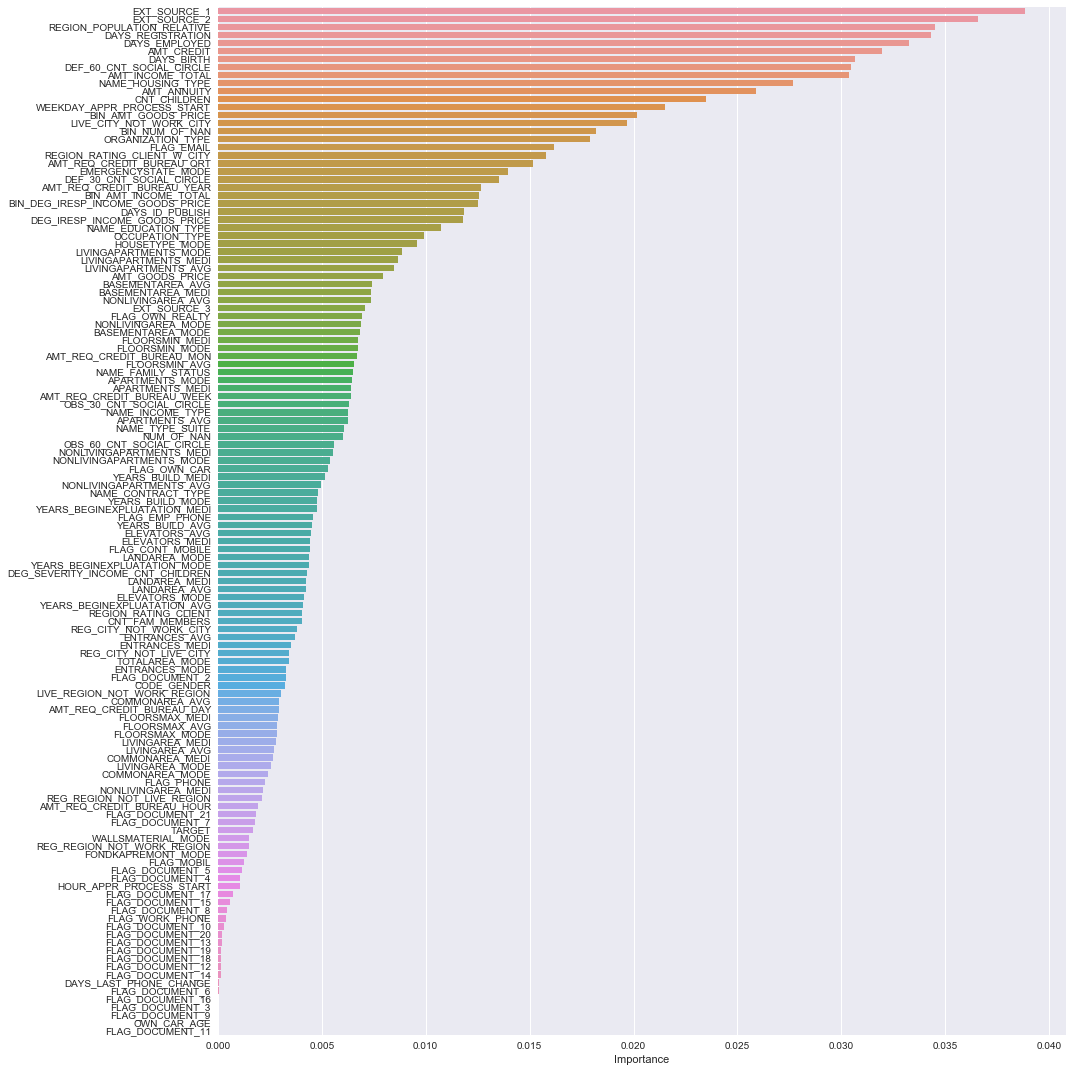

In [37]:
rank = np.argsort(-model.feature_importances_)
f, ax = plt.subplots(figsize=(15, 15)) 
sns.barplot(x=model.feature_importances_[rank], y=pd_test.columns.values[rank], orient='h')
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

In [38]:
#上位10個の特徴量を抽出
for i in range(0, 30):
    print("Rank{} => {} (Importance={:.3f})".format(i+1, pd_test.columns.values[rank[i]], model.feature_importances_[rank[i]]))

Rank1 => EXT_SOURCE_1 (Importance=0.039)
Rank2 => EXT_SOURCE_2 (Importance=0.037)
Rank3 => REGION_POPULATION_RELATIVE (Importance=0.035)
Rank4 => DAYS_REGISTRATION (Importance=0.034)
Rank5 => DAYS_EMPLOYED (Importance=0.033)
Rank6 => AMT_CREDIT (Importance=0.032)
Rank7 => DAYS_BIRTH (Importance=0.031)
Rank8 => DEF_60_CNT_SOCIAL_CIRCLE (Importance=0.030)
Rank9 => AMT_INCOME_TOTAL (Importance=0.030)
Rank10 => NAME_HOUSING_TYPE (Importance=0.028)
Rank11 => AMT_ANNUITY (Importance=0.026)
Rank12 => CNT_CHILDREN (Importance=0.023)
Rank13 => WEEKDAY_APPR_PROCESS_START (Importance=0.022)
Rank14 => BIN_AMT_GOODS_PRICE (Importance=0.020)
Rank15 => LIVE_CITY_NOT_WORK_CITY (Importance=0.020)
Rank16 => BIN_NUM_OF_NAN (Importance=0.018)
Rank17 => ORGANIZATION_TYPE (Importance=0.018)
Rank18 => FLAG_EMAIL (Importance=0.016)
Rank19 => REGION_RATING_CLIENT_W_CITY (Importance=0.016)
Rank20 => AMT_REQ_CREDIT_BUREAU_QRT (Importance=0.015)
Rank21 => EMERGENCYSTATE_MODE (Importance=0.014)
Rank22 => DEF_30_CN

In [39]:
TOP_THIRTY_COL_NAME = np.array([pd_test.columns.values[rank[i]] for i in range(0, 30)])
print(TOP_THIRTY_COL_NAME)

['EXT_SOURCE_1' 'EXT_SOURCE_2' 'REGION_POPULATION_RELATIVE'
 'DAYS_REGISTRATION' 'DAYS_EMPLOYED' 'AMT_CREDIT' 'DAYS_BIRTH'
 'DEF_60_CNT_SOCIAL_CIRCLE' 'AMT_INCOME_TOTAL' 'NAME_HOUSING_TYPE'
 'AMT_ANNUITY' 'CNT_CHILDREN' 'WEEKDAY_APPR_PROCESS_START'
 'BIN_AMT_GOODS_PRICE' 'LIVE_CITY_NOT_WORK_CITY' 'BIN_NUM_OF_NAN'
 'ORGANIZATION_TYPE' 'FLAG_EMAIL' 'REGION_RATING_CLIENT_W_CITY'
 'AMT_REQ_CREDIT_BUREAU_QRT' 'EMERGENCYSTATE_MODE'
 'DEF_30_CNT_SOCIAL_CIRCLE' 'AMT_REQ_CREDIT_BUREAU_YEAR'
 'BIN_AMT_INCOME_TOTAL' 'BIN_DEG_IRESP_INCOME_GOODS_PRICE'
 'DAYS_ID_PUBLISH' 'DEG_IRESP_INCOME_GOODS_PRICE' 'NAME_EDUCATION_TYPE'
 'OCCUPATION_TYPE' 'HOUSETYPE_MODE']


ランダムフォレストによる重要度の評価の結果、新しく導入した３つの特徴量は上位30位までに入った。３つの内一番重要度が高かったのは"BIN_NUM_OF_NAN"でNanの多さを表すものであった。（Rank=16 Importance=0.018）   
よって、新しく導入した３つの特徴量は目的変数を説明する上である程度意味がありそうである。（"DEG_IRESP_INCOME_GOODS_PRICE"については、上で確認した未返済率の傾向からは関連性があまり無さそうであったが。）

#### 新しい特徴量を加えて再度予測

In [40]:
import copy
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE",
                         "EXT_SOURCE_1",
                         "EXT_SOURCE_2",
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", 
                         "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL",
                         "BIN_NUM_OF_NAN",
                         "BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN",
                         "CNT_CHILDREN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [41]:
pd_reducted_train_data = pd_application_train[col_name]
pd_reducted_train_data.head()

,OCCUPATION_TYPE,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_EMPLOYED,DAYS_REGISTRATION,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,BIN_NUM_OF_NAN,BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN,CNT_CHILDREN,TARGET
0,Laborers,Business Entity Type 3,0.083037,0.262949,-637,-3648.0,406597.5,-9461,2.0,202500.0,0,0,0,1
1,Core staff,School,0.311267,0.622246,-1188,-1186.0,1293502.5,-16765,0.0,270000.0,0,0,0,0
2,Laborers,Government,NaN,0.555912,-225,-4260.0,135000.0,-19046,0.0,67500.0,7,0,0,0
3,Laborers,Business Entity Type 3,NaN,0.650442,-3039,-9833.0,312682.5,-19005,0.0,135000.0,9,0,0,0
4,Core staff,Religion,NaN,0.322738,-3038,-4311.0,513000.0,-19932,0.0,121500.0,8,0,0,0


In [42]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


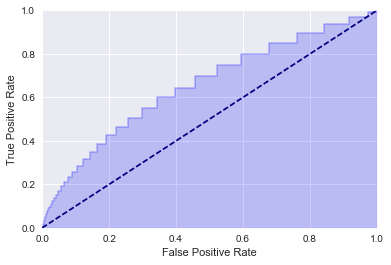

AUC=0.67295


In [43]:
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

新しいパラメータを加えて再度モデルの評価を行なった結果、AUCが0.67145から0.67295へ上がった。（AUC +0.0015）

#### 特徴量減らして再度評価を行なってみる。

In [44]:
import copy
selected_feature_name = ["OCCUPATION_TYPE", 
                         "EXT_SOURCE_2",
                         "AMT_CREDIT", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL",
                         "BIN_NUM_OF_NAN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [45]:
pd_reducted_train_data = pd_application_train[col_name]
pd_reducted_train_data.head()

,OCCUPATION_TYPE,EXT_SOURCE_2,AMT_CREDIT,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,BIN_NUM_OF_NAN,TARGET
0,Laborers,0.262949,406597.5,2.0,202500.0,0,1
1,Core staff,0.622246,1293502.5,0.0,270000.0,0,0
2,Laborers,0.555912,135000.0,0.0,67500.0,7,0
3,Laborers,0.650442,312682.5,0.0,135000.0,9,0
4,Core staff,0.322738,513000.0,0.0,121500.0,8,0


In [46]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


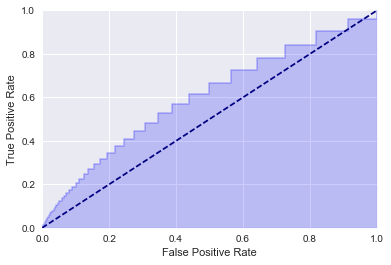

AUC=0.62264


In [47]:
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

結果、AUCが下がってしまった。特徴量を減らすのは逆効果である。

#### ランダムフォレストで抽出された上位30個の特徴量を用いて再度評価を行なってみる。

In [48]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'BIN_AMT_GOODS_PRICE',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'BIN_NUM_OF_NAN',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'BIN_AMT_INCOME_TOTAL',
                         'BIN_DEG_IRESP_INCOME_GOODS_PRICE',
                         'DAYS_ID_PUBLISH',
                         'DEG_IRESP_INCOME_GOODS_PRICE',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [49]:
pd_reducted_train_data = pd_application_train[col_name]
pd_reducted_train_data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,BIN_AMT_GOODS_PRICE,LIVE_CITY_NOT_WORK_CITY,BIN_NUM_OF_NAN,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,BIN_AMT_INCOME_TOTAL,BIN_DEG_IRESP_INCOME_GOODS_PRICE,DAYS_ID_PUBLISH,DEG_IRESP_INCOME_GOODS_PRICE,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
0,0.083037,0.262949,-3648.0,-637,0.018801,406597.5,-9461,2.0,202500.0,House / apartment,24700.5,0,WEDNESDAY,2,0,0,Business Entity Type 3,0,2,0.0,2.0,No,1.0,4.0,1,-2120,18.0,Secondary / secondary special,block of flats,Laborers,1
1,0.311267,0.622246,-1186.0,-1188,0.003541,1293502.5,-16765,0.0,270000.0,House / apartment,35698.5,0,MONDAY,6,0,0,School,0,1,0.0,0.0,No,0.0,6.0,2,-291,28.0,Higher education,block of flats,Core staff,0
2,NaN,0.555912,-4260.0,-225,0.010032,135000.0,-19046,0.0,67500.0,House / apartment,6750.0,0,MONDAY,0,0,7,Government,0,2,0.0,0.0,NaN,0.0,1.0,0,-2531,9.0,Secondary / secondary special,NaN,Laborers,0
3,NaN,0.650442,-9833.0,-3039,0.008019,312682.5,-19005,0.0,135000.0,House / apartment,29686.5,0,WEDNESDAY,1,0,9,Business Entity Type 3,0,2,NaN,0.0,NaN,NaN,3.0,1,-2437,14.0,Secondary / secondary special,NaN,Laborers,0
4,NaN,0.322738,-4311.0,-3038,0.028663,513000.0,-19932,0.0,121500.0,House / apartment,21865.5,0,THURSDAY,3,1,8,Religion,0,2,0.0,0.0,NaN,0.0,2.0,3,-3458,32.0,Secondary / secondary special,NaN,Core staff,0


In [50]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


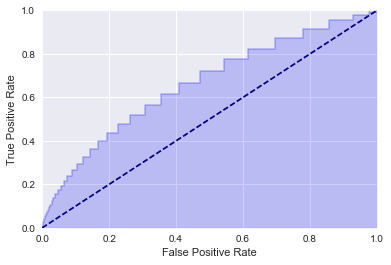

AUC=0.68148


In [51]:
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

ランダムフォレストによる重要度算出の結果から選ばれた上位３０個の特徴量を用いた結果、上位10個を用いた場合に比べAUCが0.01上がった。

### 結果まとめ
ここまでで行なった結果では、モデル入力する特徴量を増やすことが一番有効であった。

| 方法 | AUC |
|:-----------:|:-----------:|
| 重要度算出結果の上位10個を用いた場合 | 0.67145 |
| 新しい特徴量を追加した場合| 0.67295|
| 新しい特徴量を追加 <br>+ 重要度算出結果の上位30個を用いた場合 | 0.68148 |

ROC curveを計算

In [52]:
def AND_logic(x, y):
    tmp = x*0.5 + y*0.5 - 0.7
    return (tmp >= 0).astype(int)


def OR_logic(x, y):
    tmp = x*0.5 + y*0.5 - 0.2
    return (tmp >= 0).astype(int)


def NAND_logic(x, y):
    tmp = x*(-0.5) + y*(-0.5) + 0.7
    return (tmp >= 0).astype(int)


def XOR_logic(x, y):
    tmp1 = NAND_logic(x, y)
    tmp2 = OR_logic(x, y)
    tmp = AND_logic(tmp1, tmp2)
    return tmp

In [53]:
def cal_tp(test_target, result, pos_label=1):
    if pos_label==1:
        x = test_target
        y = result     
    elif pos_label==0:
        x = NAND_logic(test_target, test_target)
        y = NAND_logic(result, result)       
    
    tmp = AND_logic(x, y)
    return np.sum(tmp == 1)
    
    
def cal_fp(test_target, result, pos_label=1):
    if pos_label==1:
        x = test_target
        y = result     
    elif pos_label==0:
        x = NAND_logic(test_target, test_target)
        y = NAND_logic(result, result)
    
    tmp1 = XOR_logic(x, y)
    tmp = AND_logic(tmp1, y)
    return np.sum(tmp == 1)
    
    
def cal_tn(test_target, result, pos_label=1):
    if pos_label==0:
        x = test_target
        y = result     
    elif pos_label==1:
        x = NAND_logic(test_target, test_target)
        y = NAND_logic(result, result)

    tmp = AND_logic(x, y)
    return np.sum(tmp == 1)
    
    
def cal_fn(test_target, result, pos_label=1):
    if pos_label==1:
        x = test_target
        y = result     
    elif pos_label==0:
        x = NAND_logic(test_target, test_target)
        y = NAND_logic(result, result)

    tmp1 = XOR_logic(x, y)
    tmp = AND_logic(tmp1, x)
    return np.sum(tmp == 1)


def cal_tpr(ans, prd, pos_label=1): 
    sum_of_pos = np.sum(ans == int(pos_label))
    tpr = cal_tp(ans, prd, pos_label) / sum_of_pos
    return tpr


def cal_fpr(ans, prd, pos_label=1):
    sum_of_neg = np.sum(ans != int(pos_label))
    fpr = cal_fp(ans, prd, pos_label) / sum_of_neg
    return fpr


def cal_roc_curve(ans, prd, pos_label=1, step=10):
    #Thresholdの範囲を決める。
    t_max = ans.max()
    t_min = ans.min()
    th_max = t_max
    th_min = t_min
    th_step = (t_max - t_min)/(int)(step)
    #ansを0,1に規格化
    pos_label=1 if (int)(pos_label) == t_max else 0
    b = ans.min()
    a = ans.max()-ans.min()
    ans = (ans-b)/a
    
    #fpr, tprを計算
    fpr = np.array([cal_fpr(ans, (prd >= threshold).astype(int), pos_label) for threshold in gen_range(th_min, th_max, th_step)])
    tpr = np.array([cal_tpr(ans, (prd >= threshold).astype(int), pos_label) for threshold in gen_range(th_min, th_max, th_step)])
    threshold = np.array([threshold for threshold in gen_range(th_min, th_max, th_step)])
    
    #プロット
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.show() 

    return fpr, tpr, threshold

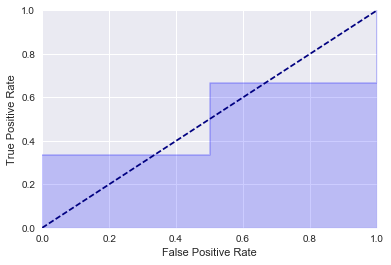

[1.  1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0. ]
[1.         0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.33333333 0.33333333]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


In [54]:
test_target = np.array([2, 0, 2, 0, 2])
result = np.array([1.9, 1.7, 1.5, 0.3, 0.1])
fpr, tpr, threshold = cal_roc_curve(test_target, result, pos_label=2)
print(fpr)
print(tpr)
print(threshold)